<a href="https://colab.research.google.com/github/data-alch3m1st/PyTorch_tinkering/blob/main/skorch_CIFAR10_cv_v003_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CIFAR-10 CNN (v009) ###

*Given the significant demands on memory (and I am using a MacBook so no CUDA for me), have to run this in Google Colab for baller T4 CUDA...*

***UPDATE:*** 

*I re-ran a skorch RandomSearchCV but with some adjustments to get better efficiency out of the grid search in order to exposed a greater number of hyper-params combinations. As such, I upped the n_iter=20 (prev. n_iter=10) and lowered the cv=2 (prev. cv=3). which increasd total iterations to 40, but getting 20 hyperparam combos instead of 10.*

In [1]:
## If running on Colab, will need to pip install skorch & torchmetrics each time;

# !pip install skorch
# !pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.6 MB/s eta 0:00:00


In [2]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skorch import NeuralNetClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix
    , accuracy_score, ConfusionMatrixDisplay
    )
from torchmetrics import Accuracy, ConfusionMatrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from timeit import default_timer as timer
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# MacoOS device agnostic code:

if torch.cuda.is_available():
    device = "cuda"  # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps"  # Use Apple Silicon GPU (if available)
else:
    device = "cpu"  # Default to CPU if no GPU is available

device

'cuda'

In [5]:
# ---------------------------------------------------------
# 1. Prepare dataset (CIFAR-10) with Augmentations
# ---------------------------------------------------------

# Train transforms (with augmentations)
train_transform_batch = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip images with 50% probability
    transforms.RandomCrop(32, padding=4),  # Add padding and crop randomly
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 stats
])

# Test transforms (only normalize)
test_transform_batch = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 stats
])

# CIFAR-10 dataset download
dataset = datasets.CIFAR10(
    './data', train=True, download=True
)

# Extract raw data and labels
X = torch.tensor(dataset.data).permute(0, 3, 1, 2).float() / 255.0  # Convert to [N, C, H, W]
y = torch.tensor(dataset.targets)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27, stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test .shape

100%|██████████| 170M/170M [00:04<00:00, 41.2MB/s]


(torch.Size([40000, 3, 32, 32]),
 torch.Size([10000, 3, 32, 32]),
 torch.Size([40000]),
 torch.Size([10000]))

In [6]:
# ---------------------------------------------------------
# 2b. Wrap in DataLoader for batching
# ---------------------------------------------------------

train_loader = DataLoader(
    list(zip(X_train, y_train))
    , batch_size=128
    , shuffle=True
)

test_loader = DataLoader(
    list(zip(X_test, y_test))
    , batch_size=128
    , shuffle=False
)

In [7]:
# ---------------------------------------------------------
# 3. Build the model class; (layers, blocks, forward, flatten, dropout, etc.)
# ---------------------------------------------------------

class Cifar10CNN_v9(nn.Module):
    def __init__(self, channels=64, dropout=0.3):
        super().__init__()
        # Convolutional block 1
        self.conv1 = nn.Conv2d(3, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)

        # Convolutional block 2
        self.conv2 = nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels * 2)

        # Convolutional block 3
        self.conv3 = nn.Conv2d(channels * 2, channels * 4, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(channels * 4)

        # Convolutional block 4
        self.conv4 = nn.Conv2d(channels * 4, channels * 8, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(channels * 8)

        # Global average pooling to reduce overfitting
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(channels * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_out = nn.Linear(256, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        # Block 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        # Block 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        # Block 4
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        # Global average pooling
        x = self.global_avgpool(x)
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(self.dropout(x)))
        return self.fc_out(x)

In [8]:
%%time
# ---------------------------------------------------------
# 4. Wrap (base model) with skorch
# ---------------------------------------------------------

net = NeuralNetClassifier(
    module=Cifar10CNN_v9
    , criterion=nn.CrossEntropyLoss
    , max_epochs=10
    , lr=0.0001
    , optimizer=torch.optim.RMSprop
    , batch_size=128
    , iterator_train__shuffle=True
    , device=device
)

net.fit(X_train, y_train)

print("Train accuracy:", net.score(X_train, y_train))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4189       0.5583        1.2401  5.7731
      2        1.0753       0.5637        1.2235  4.3306
      3        0.9375       0.6581        0.9563  4.2424
      4        0.8355       0.6348        1.0673  4.3402
      5        0.7589       0.6171        1.1556  4.3146
      6        0.6890       0.6823        0.9532  4.2646
      7        0.6288       0.6646        1.0144  4.3834
      8        0.5704       0.6686        1.0501  4.2811
      9        0.5195       0.6384        1.2147  4.2817
     10        0.4718       0.5931        1.5160  4.3775
Train accuracy: 0.66745
CPU times: user 44.6 s, sys: 847 ms, total: 45.5 s
Wall time: 46.8 s


In [9]:
# ---------------------------------------------------------
# 5a. RandomizedSearchCV for Hyperparams Tuning
# ---------------------------------------------------------

# (param_dist_v6) # Removed torch.optim.Adam, and 64 batch_size to increase coverage in grid_search (as these are not likely ideal for this model and are just wasting space/time in a grid_search;)

param_dist = {
    "module__channels": [64, 128]  # Increasing upper range
    , "module__dropout": [0.2, 0.3]  # Slightly reduced dropout values
    , "lr": [1e-4, 3e-4, 1e-3]  # Removed extreme values for better control
    , "optimizer": [torch.optim.SGD, torch.optim.RMSprop]   # torch.optim.Adam,
    , "batch_size": [128]  # Added smaller batch size for exploration # 64,
    , "optimizer__momentum": [0.0, 0.9]
    , "optimizer__weight_decay": [0.0, 1e-4, 5e-4]
}

In [10]:
%%time
# ---------------------------------------------------------
# 5b. Randomized Search Actual (sample combos, actual run;)
# ---------------------------------------------------------

rs = RandomizedSearchCV(
    estimator=net
    , param_distributions=param_dist
    , n_iter=20
    , cv=2
    , scoring="accuracy"
    , verbose=1
    , random_state=27
    , n_jobs=-1
)

rs.fit(X_train, y_train)

print("Best CV accuracy:", rs.best_score_)
print("Best params:", rs.best_params_)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4547       0.5511        1.2331  9.7779
      2        1.0279       0.6096        1.1002  9.8031
      3        0.8490       0.7055        0.8462  9.8180
      4        0.7220       0.6843        0.9094  9.8204
      5        0.6425       0.6743        0.9541  9.8296
      6        0.5704       0.6614        1.1459  9.7514
      7        0.4933       0.7498        0.7820  9.8247
      8        0.4390       0.6160        1.4061  9.8263
      9        0.3856       0.7331        0.8469  9.8071
     10        0.3416       0.7671        0.7581  9.7639
Best CV accuracy: 0.686325
Best params: {'optimizer__weight_decay': 0.0001, 'optimizer__momentum': 0.0, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'module__dropout': 0.3, 'module__channels': 128, 'lr': 0.0003, 'batch_size': 128}
CPU times: user 1

In [11]:
rs.best_params_

{'optimizer__weight_decay': 0.0001,
 'optimizer__momentum': 0.0,
 'optimizer': torch.optim.rmsprop.RMSprop,
 'module__dropout': 0.3,
 'module__channels': 128,
 'lr': 0.0003,
 'batch_size': 128}

In [13]:
# ---------------------------------------------------------
# 6. Send results to a dataframe for clean review;
# ---------------------------------------------------------

results_v9 = pd.DataFrame(rs.cv_results_)
results_v9[[
    "mean_test_score"
    , "std_test_score"
    , "params"
]].sort_values("mean_test_score", ascending=False, inplace=True)
results_v9.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer__weight_decay,param_optimizer__momentum,param_optimizer,param_module__dropout,param_module__channels,param_lr,param_batch_size,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,102.450975,0.389766,3.013166,0.774118,0.0001,0.0,<class 'torch.optim.rmsprop.RMSprop'>,0.3,128,0.0003,128,"{'optimizer__weight_decay': 0.0001, 'optimizer...",0.74215,0.63050,0.686325,0.055825,1
1,40.800192,0.195213,1.656367,0.019327,0.0005,0.9,<class 'torch.optim.rmsprop.RMSprop'>,0.3,64,0.0010,128,"{'optimizer__weight_decay': 0.0005, 'optimizer...",0.60095,0.43845,0.519700,0.081250,10
2,96.508720,0.603892,3.249293,0.518854,0.0005,0.0,<class 'torch.optim.sgd.SGD'>,0.3,128,0.0001,128,"{'optimizer__weight_decay': 0.0005, 'optimizer...",0.19505,0.17460,0.184825,0.010225,19
3,41.979588,0.144578,1.565844,0.123472,0.0001,0.0,<class 'torch.optim.sgd.SGD'>,0.3,64,0.0010,128,"{'optimizer__weight_decay': 0.0001, 'optimizer...",0.30045,0.29495,0.297700,0.002750,14
4,96.528429,0.748957,2.978017,0.758660,0.0005,0.0,<class 'torch.optim.sgd.SGD'>,0.2,128,0.0010,128,"{'optimizer__weight_decay': 0.0005, 'optimizer...",0.35850,0.34905,0.353775,0.004725,12


In [14]:
results_v9.sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer__weight_decay,param_optimizer__momentum,param_optimizer,param_module__dropout,param_module__channels,param_lr,param_batch_size,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,102.450975,0.389766,3.013166,0.774118,0.0001,0.0,<class 'torch.optim.rmsprop.RMSprop'>,0.3,128,0.0003,128,"{'optimizer__weight_decay': 0.0001, 'optimizer...",0.74215,0.63050,0.686325,0.055825,1
9,41.619983,0.059194,1.654275,0.020990,0.0000,0.9,<class 'torch.optim.rmsprop.RMSprop'>,0.2,64,0.0001,128,"{'optimizer__weight_decay': 0.0, 'optimizer__m...",0.60005,0.69225,0.646150,0.046100,2
10,100.608115,0.691507,3.015260,0.751243,0.0005,0.9,<class 'torch.optim.rmsprop.RMSprop'>,0.3,128,0.0001,128,"{'optimizer__weight_decay': 0.0005, 'optimizer...",0.65770,0.63210,0.644900,0.012800,3
17,41.108787,0.008915,1.587492,0.117612,0.0001,0.9,<class 'torch.optim.rmsprop.RMSprop'>,0.2,64,0.0003,128,"{'optimizer__weight_decay': 0.0001, 'optimizer...",0.59420,0.66950,0.631850,0.037650,4
14,99.929074,0.822739,2.978189,0.773335,0.0001,0.0,<class 'torch.optim.rmsprop.RMSprop'>,0.3,128,0.0010,128,"{'optimizer__weight_decay': 0.0001, 'optimizer...",0.66005,0.60095,0.630500,0.029550,5


In [15]:
print(results_v9.sort_values(by='rank_test_score', ascending=True)['params'].iloc[0])
print(results_v9.sort_values(by='rank_test_score', ascending=True)['params'].iloc[1])
print(results_v9.sort_values(by='rank_test_score', ascending=True)['params'].iloc[2])

{'optimizer__weight_decay': 0.0001, 'optimizer__momentum': 0.0, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'module__dropout': 0.3, 'module__channels': 128, 'lr': 0.0003, 'batch_size': 128}
{'optimizer__weight_decay': 0.0, 'optimizer__momentum': 0.9, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'module__dropout': 0.2, 'module__channels': 64, 'lr': 0.0001, 'batch_size': 128}
{'optimizer__weight_decay': 0.0005, 'optimizer__momentum': 0.9, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'module__dropout': 0.3, 'module__channels': 128, 'lr': 0.0001, 'batch_size': 128}


In [20]:
# from google.colab import drive
# drive.mount('/content/drive')   # follow the auth steps
results_v9.to_csv('/content/drive/MyDrive/results_v9.csv', index=False)

In [22]:
# 2) Inspect the current Colab VM working directory
import os
print("Colab VM cwd:", os.getcwd())
print("Files in /content:", os.listdir('/content'))

# 3) Define the Drive path you want to use
# Note: "MyDrive" is the mount point for "My Drive"
drive_folder = '/content/drive/MyDrive/Colab Notebooks/PyTorch_tinkering'

# 4) Create the target folder if it doesn't exist
os.makedirs(drive_folder, exist_ok=True)
print("Target folder ready at:", drive_folder)

# 5) Save the DataFrame to that folder
# replace `results` with your actual DataFrame variable name
csv_path = os.path.join(drive_folder, 'results_v9.csv')
results_v9.to_csv(csv_path, index=False)
print("Saved CSV to:", csv_path)

Colab VM cwd: /content
Files in /content: ['.config', 'drive', 'data', 'sample_data']
Target folder ready at: /content/drive/MyDrive/Colab Notebooks/PyTorch_tinkering
Saved CSV to: /content/drive/MyDrive/Colab Notebooks/PyTorch_tinkering/results_v9.csv


In [24]:
results_v9.to_csv("results_v9.csv", index=False)

In [25]:
from google.colab import files
files.download("results_v9.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
rs.best_estimator_
rs.best_params_
rs.get_params
rs.cv_results_

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Cifar10CNN_v9(
    (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (global_avgpool): AdaptiveAvgPool2d(output_size=1)
    (fc1): Linear(in_features=1024, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc_out): Linear(in_features=256, out_features=10, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  ),
)

{'optimizer__weight_decay': 0.0001,
 'optimizer__momentum': 0.0,
 'optimizer': torch.optim.rmsprop.RMSprop,
 'module__dropout': 0.3,
 'module__channels': 128,
 'lr': 0.0003,
 'batch_size': 128}

<bound method BaseEstimator.get_params of RandomizedSearchCV(cv=2,
                   estimator=NeuralNetClassifier(_params_to_validate={'iterator_train__shuffle'}, batch_size=128, callbacks=None, compile=False, criterion=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, dataset=<class 'skorch.dataset.Dataset'>, device='cuda', iterator_train=<class 'torch.utils.data.dataloader.DataLoader'>, iterator_train__shuffle=True,...e),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'batch_size': [128],
                                        'lr': [0.0001, 0.0003, 0.001],
                                        'module__channels': [64, 128],
                                        'module__dropout': [0.2, 0.3],
                                        'optimizer': [<class 'torch.optim.sgd.SGD'>,
                                                      <class 'torch.optim.rmsprop.RMSprop'>],
                                        'optimizer__momentum': [0.0, 0.9],
                                        'optimizer__weight_decay': [0.0, 0.0001,
                                                                    0.0005]},
                   random_state=27, scoring='accuracy', verbose=1)>

{'mean_fit_time': array([102.45097494,  40.80019188,  96.5087198 ,  41.97958767,
         96.52842903,  41.65803123,  96.56148469,  40.78692734,
         41.67225838,  41.61998343, 100.6081152 ,  41.70570993,
         99.64619136,  43.67226017,  99.92907393,  96.13287544,
         98.83320928,  41.1087867 ,  40.40086865,  95.25447726]),
 'std_fit_time': array([0.3897655 , 0.19521284, 0.60389173, 0.1445781 , 0.74895716,
        0.0650754 , 0.93300092, 0.12464964, 0.11580873, 0.05919409,
        0.69150662, 0.14420605, 0.87085342, 0.20640934, 0.82273853,
        0.78064322, 0.84958577, 0.00891531, 0.20603323, 0.46499252]),
 'mean_score_time': array([3.01316559, 1.65636706, 3.24929273, 1.56584418, 2.97801721,
        1.69898641, 3.02146077, 1.62571466, 1.50971818, 1.65427542,
        3.0152601 , 1.743312  , 3.0298301 , 1.68382204, 2.97818947,
        2.94599783, 2.98596489, 1.58749199, 1.83656502, 2.83872354]),
 'std_score_time': array([0.77411759, 0.01932669, 0.5188545 , 0.12347186, 0.75

In [1]:
# rs.cv_results_

In [27]:
rs.best_index_

np.int64(0)

In [28]:
# ---------------------------------------------------------
# 7a. Predict & Evaluate Performance with Best Model (Metrics)
# ---------------------------------------------------------

best_model = rs.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:\n", accuracy_score(y_test, y_pred))
print('\n=================================================================\n')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('\n=================================================================\n')
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = ConfusionMatrix(num_classes=10, task='multiclass')
cm_tensor = cm(torch.tensor(y_pred), y_test)

Accuracy:
 0.7635


Confusion Matrix:
 [[730  25  35  69  35   1  11  24  12  58]
 [  4 910   3   2   1   0  18   0   4  58]
 [ 40   4 636 158  63   9  66  22   0   2]
 [  7   2  33 805  43  17  74  12   3   4]
 [  6   1  28  71 809   5  49  26   1   4]
 [  1   4  24 412  62 413  36  45   2   1]
 [  6   4  21  57  14   0 896   1   0   1]
 [  3   1  24  91  70  12  10 786   0   3]
 [ 40  28  16  63  14   0  36   6 758  39]
 [  6  46   3  25   4   1  15   5   3 892]]


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.73      0.79      1000
           1       0.89      0.91      0.90      1000
           2       0.77      0.64      0.70      1000
           3       0.46      0.81      0.58      1000
           4       0.73      0.81      0.77      1000
           5       0.90      0.41      0.57      1000
           6       0.74      0.90      0.81      1000
           7       0.85      0.79      0.82      1000
           8     

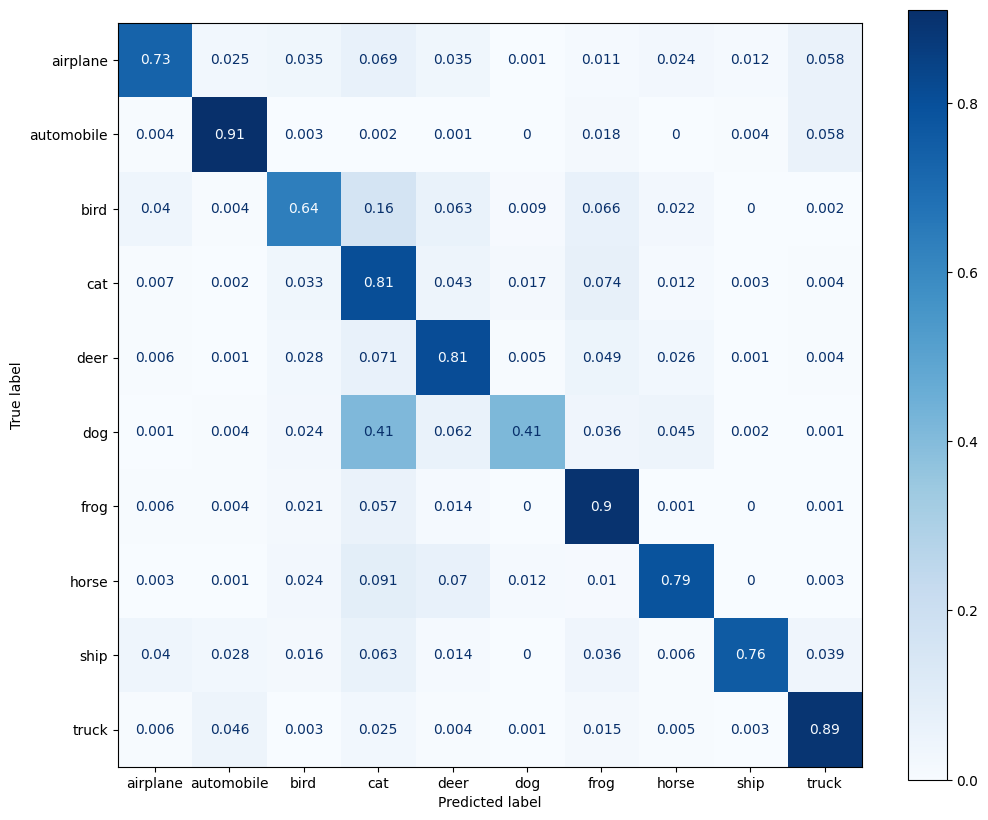

In [30]:
# 7b. Plot the Confusion Matrix (Visualized Metrics)

fig, ax = plt.subplots(figsize=(12, 10))

# disp = ConfusionMatrixDisplay.from_predictions(
#     y_test, y_pred
#     , display_labels=dataset.classes
#     , cmap='Blues'
#     , normalize='true', xticks_rotation=45
# )

disp.plot(ax=ax, cmap='Blues')
plt.show();

In [36]:
# 8. Functionize the train & test loop(s):

def train_step(model, loader, loss_fn, optimizer, accuracy_fn, device):
    model.train()
    total_loss, total_acc = 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        # Apply train transforms to the batch
        X = train_transform_batch(X)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()
    return total_loss / len(loader), total_acc / len(loader)

def test_step(model, loader, loss_fn, accuracy_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            # Apply test transforms to the batch
            X = test_transform_batch(X)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()
            total_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()
    return total_loss / len(loader), total_acc / len(loader) # Return test loss

In [37]:
# ---------------------------------------------------------
# 9. Set the final model with the best params (including channels & dropout)
# ---------------------------------------------------------

model = Cifar10CNN_v9(
    channels=rs.best_params_["module__channels"]
    , dropout=rs.best_params_["module__dropout"]
).to(device)

model

Cifar10CNN_v9(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avgpool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
"""
# Old model.train params (keeping handy for a rainy day;;;):
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

"""

In [38]:
%%time

# 10. Train the Best Model

epochs = 100  # For CIFAR-10, can start w/ 50 and do add'l 50 retrain if needed OR just go full 100;

optimizer = rs.best_params_["optimizer"](model.parameters(), lr=rs.best_params_["lr"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7, min_lr=0.00001)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = Accuracy(task='multiclass', num_classes=10).to(device)


for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        model, train_loader, loss_fn, optimizer, accuracy_fn, device)
    test_loss, test_acc = test_step(
        model, test_loader, loss_fn, accuracy_fn, device)
    scheduler.step(test_loss)  # Update learning rate with test_loss
    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} - "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}"
    )

  1%|          | 1/100 [00:11<19:01, 11.53s/it]

Epoch 1/100 - Train Loss: 1.5393, Train Acc: 0.42 - Test Loss: 1.4713, Test Acc: 0.47


  2%|▏         | 2/100 [00:22<18:43, 11.46s/it]

Epoch 2/100 - Train Loss: 1.1390, Train Acc: 0.59 - Test Loss: 1.4198, Test Acc: 0.53


  3%|▎         | 3/100 [00:34<18:32, 11.47s/it]

Epoch 3/100 - Train Loss: 0.9740, Train Acc: 0.65 - Test Loss: 0.9474, Test Acc: 0.66


  4%|▍         | 4/100 [00:46<18:41, 11.68s/it]

Epoch 4/100 - Train Loss: 0.8722, Train Acc: 0.69 - Test Loss: 1.0240, Test Acc: 0.65


  5%|▌         | 5/100 [00:58<18:32, 11.71s/it]

Epoch 5/100 - Train Loss: 0.8012, Train Acc: 0.72 - Test Loss: 0.8310, Test Acc: 0.71


  6%|▌         | 6/100 [01:10<18:40, 11.92s/it]

Epoch 6/100 - Train Loss: 0.7508, Train Acc: 0.74 - Test Loss: 1.0860, Test Acc: 0.64


  7%|▋         | 7/100 [01:22<18:29, 11.93s/it]

Epoch 7/100 - Train Loss: 0.7026, Train Acc: 0.75 - Test Loss: 1.0117, Test Acc: 0.66


  8%|▊         | 8/100 [01:34<18:17, 11.93s/it]

Epoch 8/100 - Train Loss: 0.6743, Train Acc: 0.77 - Test Loss: 1.0674, Test Acc: 0.67


  9%|▉         | 9/100 [01:46<18:05, 11.93s/it]

Epoch 9/100 - Train Loss: 0.6406, Train Acc: 0.78 - Test Loss: 0.7615, Test Acc: 0.74


 10%|█         | 10/100 [01:58<17:53, 11.93s/it]

Epoch 10/100 - Train Loss: 0.6108, Train Acc: 0.79 - Test Loss: 0.8012, Test Acc: 0.73


 11%|█         | 11/100 [02:09<17:35, 11.86s/it]

Epoch 11/100 - Train Loss: 0.5858, Train Acc: 0.80 - Test Loss: 0.9474, Test Acc: 0.70


 12%|█▏        | 12/100 [02:21<17:20, 11.82s/it]

Epoch 12/100 - Train Loss: 0.5600, Train Acc: 0.81 - Test Loss: 0.9547, Test Acc: 0.71


 13%|█▎        | 13/100 [02:33<17:09, 11.83s/it]

Epoch 13/100 - Train Loss: 0.5389, Train Acc: 0.81 - Test Loss: 1.1093, Test Acc: 0.68


 14%|█▍        | 14/100 [02:45<16:56, 11.82s/it]

Epoch 14/100 - Train Loss: 0.5231, Train Acc: 0.82 - Test Loss: 0.5904, Test Acc: 0.80


 15%|█▌        | 15/100 [02:57<16:45, 11.83s/it]

Epoch 15/100 - Train Loss: 0.5074, Train Acc: 0.82 - Test Loss: 0.6003, Test Acc: 0.80


 16%|█▌        | 16/100 [03:09<16:46, 11.98s/it]

Epoch 16/100 - Train Loss: 0.4857, Train Acc: 0.83 - Test Loss: 0.5827, Test Acc: 0.81


 17%|█▋        | 17/100 [03:21<16:30, 11.94s/it]

Epoch 17/100 - Train Loss: 0.4706, Train Acc: 0.84 - Test Loss: 0.7980, Test Acc: 0.75


 18%|█▊        | 18/100 [03:33<16:19, 11.95s/it]

Epoch 18/100 - Train Loss: 0.4585, Train Acc: 0.84 - Test Loss: 0.6491, Test Acc: 0.79


 19%|█▉        | 19/100 [03:45<16:21, 12.11s/it]

Epoch 19/100 - Train Loss: 0.4464, Train Acc: 0.84 - Test Loss: 0.7024, Test Acc: 0.76


 20%|██        | 20/100 [03:57<16:04, 12.05s/it]

Epoch 20/100 - Train Loss: 0.4327, Train Acc: 0.85 - Test Loss: 0.7731, Test Acc: 0.76


 21%|██        | 21/100 [04:09<15:48, 12.01s/it]

Epoch 21/100 - Train Loss: 0.4195, Train Acc: 0.85 - Test Loss: 0.6291, Test Acc: 0.81


 22%|██▏       | 22/100 [04:21<15:34, 11.98s/it]

Epoch 22/100 - Train Loss: 0.4042, Train Acc: 0.86 - Test Loss: 1.0976, Test Acc: 0.70


 23%|██▎       | 23/100 [04:33<15:19, 11.94s/it]

Epoch 23/100 - Train Loss: 0.3919, Train Acc: 0.86 - Test Loss: 0.5632, Test Acc: 0.82


 24%|██▍       | 24/100 [04:45<15:17, 12.07s/it]

Epoch 24/100 - Train Loss: 0.3861, Train Acc: 0.87 - Test Loss: 0.5043, Test Acc: 0.84


 25%|██▌       | 25/100 [04:57<15:06, 12.09s/it]

Epoch 25/100 - Train Loss: 0.3679, Train Acc: 0.87 - Test Loss: 0.4502, Test Acc: 0.85


 26%|██▌       | 26/100 [05:09<14:49, 12.03s/it]

Epoch 26/100 - Train Loss: 0.3609, Train Acc: 0.87 - Test Loss: 0.5533, Test Acc: 0.82


 27%|██▋       | 27/100 [05:21<14:35, 11.99s/it]

Epoch 27/100 - Train Loss: 0.3513, Train Acc: 0.88 - Test Loss: 0.5683, Test Acc: 0.83


 28%|██▊       | 28/100 [05:33<14:22, 11.98s/it]

Epoch 28/100 - Train Loss: 0.3373, Train Acc: 0.88 - Test Loss: 0.7032, Test Acc: 0.80


 29%|██▉       | 29/100 [05:45<14:10, 11.98s/it]

Epoch 29/100 - Train Loss: 0.3388, Train Acc: 0.88 - Test Loss: 0.4295, Test Acc: 0.86


 30%|███       | 30/100 [05:57<13:58, 11.98s/it]

Epoch 30/100 - Train Loss: 0.3278, Train Acc: 0.89 - Test Loss: 0.6714, Test Acc: 0.79


 31%|███       | 31/100 [06:09<13:47, 11.99s/it]

Epoch 31/100 - Train Loss: 0.3122, Train Acc: 0.89 - Test Loss: 0.6239, Test Acc: 0.81


 32%|███▏      | 32/100 [06:22<13:43, 12.11s/it]

Epoch 32/100 - Train Loss: 0.3031, Train Acc: 0.89 - Test Loss: 0.6037, Test Acc: 0.82


 33%|███▎      | 33/100 [06:34<13:35, 12.17s/it]

Epoch 33/100 - Train Loss: 0.3036, Train Acc: 0.89 - Test Loss: 0.5107, Test Acc: 0.84


 34%|███▍      | 34/100 [06:46<13:18, 12.10s/it]

Epoch 34/100 - Train Loss: 0.2925, Train Acc: 0.90 - Test Loss: 0.5626, Test Acc: 0.83


 35%|███▌      | 35/100 [06:58<13:03, 12.05s/it]

Epoch 35/100 - Train Loss: 0.2901, Train Acc: 0.90 - Test Loss: 0.4936, Test Acc: 0.84


 36%|███▌      | 36/100 [07:10<12:49, 12.02s/it]

Epoch 36/100 - Train Loss: 0.2805, Train Acc: 0.90 - Test Loss: 0.5674, Test Acc: 0.83


 37%|███▋      | 37/100 [07:22<12:36, 12.00s/it]

Epoch 37/100 - Train Loss: 0.2685, Train Acc: 0.91 - Test Loss: 0.5278, Test Acc: 0.84


 38%|███▊      | 38/100 [07:34<12:24, 12.00s/it]

Epoch 38/100 - Train Loss: 0.2088, Train Acc: 0.93 - Test Loss: 0.3656, Test Acc: 0.89


 39%|███▉      | 39/100 [07:46<12:11, 11.99s/it]

Epoch 39/100 - Train Loss: 0.1843, Train Acc: 0.94 - Test Loss: 0.3685, Test Acc: 0.89


 40%|████      | 40/100 [07:58<11:59, 11.98s/it]

Epoch 40/100 - Train Loss: 0.1757, Train Acc: 0.94 - Test Loss: 0.3579, Test Acc: 0.89


 41%|████      | 41/100 [08:10<11:47, 11.99s/it]

Epoch 41/100 - Train Loss: 0.1664, Train Acc: 0.94 - Test Loss: 0.3706, Test Acc: 0.89


 42%|████▏     | 42/100 [08:21<11:34, 11.98s/it]

Epoch 42/100 - Train Loss: 0.1629, Train Acc: 0.94 - Test Loss: 0.3601, Test Acc: 0.89


 43%|████▎     | 43/100 [08:33<11:22, 11.97s/it]

Epoch 43/100 - Train Loss: 0.1567, Train Acc: 0.95 - Test Loss: 0.3759, Test Acc: 0.89


 44%|████▍     | 44/100 [08:45<11:10, 11.97s/it]

Epoch 44/100 - Train Loss: 0.1586, Train Acc: 0.95 - Test Loss: 0.3818, Test Acc: 0.89


 45%|████▌     | 45/100 [08:57<10:58, 11.97s/it]

Epoch 45/100 - Train Loss: 0.1557, Train Acc: 0.95 - Test Loss: 0.3788, Test Acc: 0.89


 46%|████▌     | 46/100 [09:09<10:46, 11.97s/it]

Epoch 46/100 - Train Loss: 0.1514, Train Acc: 0.95 - Test Loss: 0.3656, Test Acc: 0.90


 47%|████▋     | 47/100 [09:21<10:34, 11.97s/it]

Epoch 47/100 - Train Loss: 0.1466, Train Acc: 0.95 - Test Loss: 0.3780, Test Acc: 0.89


 48%|████▊     | 48/100 [09:33<10:22, 11.97s/it]

Epoch 48/100 - Train Loss: 0.1464, Train Acc: 0.95 - Test Loss: 0.3811, Test Acc: 0.89


 49%|████▉     | 49/100 [09:45<10:10, 11.97s/it]

Epoch 49/100 - Train Loss: 0.1381, Train Acc: 0.95 - Test Loss: 0.3694, Test Acc: 0.89


 50%|█████     | 50/100 [09:57<09:58, 11.96s/it]

Epoch 50/100 - Train Loss: 0.1374, Train Acc: 0.95 - Test Loss: 0.3709, Test Acc: 0.89


 51%|█████     | 51/100 [10:09<09:46, 11.96s/it]

Epoch 51/100 - Train Loss: 0.1341, Train Acc: 0.95 - Test Loss: 0.3750, Test Acc: 0.89


 52%|█████▏    | 52/100 [10:21<09:34, 11.97s/it]

Epoch 52/100 - Train Loss: 0.1361, Train Acc: 0.95 - Test Loss: 0.3681, Test Acc: 0.90


 53%|█████▎    | 53/100 [10:33<09:22, 11.96s/it]

Epoch 53/100 - Train Loss: 0.1368, Train Acc: 0.95 - Test Loss: 0.3707, Test Acc: 0.89


 54%|█████▍    | 54/100 [10:45<09:10, 11.96s/it]

Epoch 54/100 - Train Loss: 0.1318, Train Acc: 0.95 - Test Loss: 0.3661, Test Acc: 0.89


 55%|█████▌    | 55/100 [10:57<08:58, 11.96s/it]

Epoch 55/100 - Train Loss: 0.1322, Train Acc: 0.95 - Test Loss: 0.3695, Test Acc: 0.90


 56%|█████▌    | 56/100 [11:09<08:46, 11.96s/it]

Epoch 56/100 - Train Loss: 0.1354, Train Acc: 0.95 - Test Loss: 0.3767, Test Acc: 0.89


 57%|█████▋    | 57/100 [11:21<08:34, 11.96s/it]

Epoch 57/100 - Train Loss: 0.1331, Train Acc: 0.95 - Test Loss: 0.3670, Test Acc: 0.89


 58%|█████▊    | 58/100 [11:33<08:22, 11.96s/it]

Epoch 58/100 - Train Loss: 0.1315, Train Acc: 0.95 - Test Loss: 0.3833, Test Acc: 0.89


 59%|█████▉    | 59/100 [11:45<08:10, 11.95s/it]

Epoch 59/100 - Train Loss: 0.1307, Train Acc: 0.95 - Test Loss: 0.3661, Test Acc: 0.90


 60%|██████    | 60/100 [11:57<07:58, 11.95s/it]

Epoch 60/100 - Train Loss: 0.1278, Train Acc: 0.96 - Test Loss: 0.3653, Test Acc: 0.90


 61%|██████    | 61/100 [12:09<07:46, 11.95s/it]

Epoch 61/100 - Train Loss: 0.1314, Train Acc: 0.95 - Test Loss: 0.3678, Test Acc: 0.90


 62%|██████▏   | 62/100 [12:21<07:34, 11.97s/it]

Epoch 62/100 - Train Loss: 0.1278, Train Acc: 0.96 - Test Loss: 0.3755, Test Acc: 0.89


 63%|██████▎   | 63/100 [12:33<07:22, 11.96s/it]

Epoch 63/100 - Train Loss: 0.1278, Train Acc: 0.96 - Test Loss: 0.3696, Test Acc: 0.90


 64%|██████▍   | 64/100 [12:45<07:10, 11.96s/it]

Epoch 64/100 - Train Loss: 0.1234, Train Acc: 0.96 - Test Loss: 0.3739, Test Acc: 0.90


 65%|██████▌   | 65/100 [12:57<06:58, 11.96s/it]

Epoch 65/100 - Train Loss: 0.1281, Train Acc: 0.96 - Test Loss: 0.3749, Test Acc: 0.89


 66%|██████▌   | 66/100 [13:08<06:46, 11.95s/it]

Epoch 66/100 - Train Loss: 0.1248, Train Acc: 0.96 - Test Loss: 0.3732, Test Acc: 0.90


 67%|██████▋   | 67/100 [13:20<06:34, 11.95s/it]

Epoch 67/100 - Train Loss: 0.1244, Train Acc: 0.96 - Test Loss: 0.3715, Test Acc: 0.90


 68%|██████▊   | 68/100 [13:32<06:22, 11.94s/it]

Epoch 68/100 - Train Loss: 0.1215, Train Acc: 0.96 - Test Loss: 0.3742, Test Acc: 0.90


 69%|██████▉   | 69/100 [13:44<06:10, 11.94s/it]

Epoch 69/100 - Train Loss: 0.1228, Train Acc: 0.96 - Test Loss: 0.3763, Test Acc: 0.89


 70%|███████   | 70/100 [13:56<05:58, 11.95s/it]

Epoch 70/100 - Train Loss: 0.1216, Train Acc: 0.96 - Test Loss: 0.3871, Test Acc: 0.89


 71%|███████   | 71/100 [14:08<05:46, 11.95s/it]

Epoch 71/100 - Train Loss: 0.1187, Train Acc: 0.96 - Test Loss: 0.3847, Test Acc: 0.89


 72%|███████▏  | 72/100 [14:20<05:34, 11.94s/it]

Epoch 72/100 - Train Loss: 0.1187, Train Acc: 0.96 - Test Loss: 0.3770, Test Acc: 0.90


 73%|███████▎  | 73/100 [14:32<05:22, 11.95s/it]

Epoch 73/100 - Train Loss: 0.1210, Train Acc: 0.96 - Test Loss: 0.3825, Test Acc: 0.90


 74%|███████▍  | 74/100 [14:44<05:10, 11.95s/it]

Epoch 74/100 - Train Loss: 0.1192, Train Acc: 0.96 - Test Loss: 0.3755, Test Acc: 0.90


 75%|███████▌  | 75/100 [14:56<04:59, 11.96s/it]

Epoch 75/100 - Train Loss: 0.1205, Train Acc: 0.96 - Test Loss: 0.3775, Test Acc: 0.90


 76%|███████▌  | 76/100 [15:08<04:47, 11.98s/it]

Epoch 76/100 - Train Loss: 0.1199, Train Acc: 0.96 - Test Loss: 0.3757, Test Acc: 0.90


 77%|███████▋  | 77/100 [15:20<04:35, 12.00s/it]

Epoch 77/100 - Train Loss: 0.1170, Train Acc: 0.96 - Test Loss: 0.3810, Test Acc: 0.90


 78%|███████▊  | 78/100 [15:32<04:23, 11.99s/it]

Epoch 78/100 - Train Loss: 0.1135, Train Acc: 0.96 - Test Loss: 0.3825, Test Acc: 0.90


 79%|███████▉  | 79/100 [15:44<04:11, 11.98s/it]

Epoch 79/100 - Train Loss: 0.1153, Train Acc: 0.96 - Test Loss: 0.3843, Test Acc: 0.90


 80%|████████  | 80/100 [15:56<03:59, 11.99s/it]

Epoch 80/100 - Train Loss: 0.1161, Train Acc: 0.96 - Test Loss: 0.3782, Test Acc: 0.90


 81%|████████  | 81/100 [16:08<03:47, 11.98s/it]

Epoch 81/100 - Train Loss: 0.1140, Train Acc: 0.96 - Test Loss: 0.3854, Test Acc: 0.90


 82%|████████▏ | 82/100 [16:20<03:35, 11.99s/it]

Epoch 82/100 - Train Loss: 0.1132, Train Acc: 0.96 - Test Loss: 0.3801, Test Acc: 0.90


 83%|████████▎ | 83/100 [16:32<03:24, 12.02s/it]

Epoch 83/100 - Train Loss: 0.1133, Train Acc: 0.96 - Test Loss: 0.3792, Test Acc: 0.90


 84%|████████▍ | 84/100 [16:44<03:13, 12.07s/it]

Epoch 84/100 - Train Loss: 0.1162, Train Acc: 0.96 - Test Loss: 0.3801, Test Acc: 0.90


 85%|████████▌ | 85/100 [16:57<03:01, 12.12s/it]

Epoch 85/100 - Train Loss: 0.1125, Train Acc: 0.96 - Test Loss: 0.3832, Test Acc: 0.90


 86%|████████▌ | 86/100 [17:09<02:49, 12.12s/it]

Epoch 86/100 - Train Loss: 0.1123, Train Acc: 0.96 - Test Loss: 0.3873, Test Acc: 0.90


 87%|████████▋ | 87/100 [17:21<02:37, 12.11s/it]

Epoch 87/100 - Train Loss: 0.1107, Train Acc: 0.96 - Test Loss: 0.3907, Test Acc: 0.89


 88%|████████▊ | 88/100 [17:33<02:25, 12.11s/it]

Epoch 88/100 - Train Loss: 0.1121, Train Acc: 0.96 - Test Loss: 0.3793, Test Acc: 0.90


 89%|████████▉ | 89/100 [17:45<02:13, 12.10s/it]

Epoch 89/100 - Train Loss: 0.1097, Train Acc: 0.96 - Test Loss: 0.3849, Test Acc: 0.90


 90%|█████████ | 90/100 [17:57<02:01, 12.10s/it]

Epoch 90/100 - Train Loss: 0.1102, Train Acc: 0.96 - Test Loss: 0.3848, Test Acc: 0.90


 91%|█████████ | 91/100 [18:09<01:48, 12.10s/it]

Epoch 91/100 - Train Loss: 0.1086, Train Acc: 0.96 - Test Loss: 0.3896, Test Acc: 0.90


 92%|█████████▏| 92/100 [18:21<01:36, 12.10s/it]

Epoch 92/100 - Train Loss: 0.1118, Train Acc: 0.96 - Test Loss: 0.3899, Test Acc: 0.89


 93%|█████████▎| 93/100 [18:33<01:24, 12.10s/it]

Epoch 93/100 - Train Loss: 0.1099, Train Acc: 0.96 - Test Loss: 0.3876, Test Acc: 0.90


 94%|█████████▍| 94/100 [18:45<01:12, 12.11s/it]

Epoch 94/100 - Train Loss: 0.1082, Train Acc: 0.96 - Test Loss: 0.3873, Test Acc: 0.90


 95%|█████████▌| 95/100 [18:58<01:00, 12.11s/it]

Epoch 95/100 - Train Loss: 0.1101, Train Acc: 0.96 - Test Loss: 0.3923, Test Acc: 0.90


 96%|█████████▌| 96/100 [19:10<00:48, 12.11s/it]

Epoch 96/100 - Train Loss: 0.1099, Train Acc: 0.96 - Test Loss: 0.3910, Test Acc: 0.90


 97%|█████████▋| 97/100 [19:22<00:36, 12.08s/it]

Epoch 97/100 - Train Loss: 0.1050, Train Acc: 0.96 - Test Loss: 0.3985, Test Acc: 0.90


 98%|█████████▊| 98/100 [19:34<00:24, 12.07s/it]

Epoch 98/100 - Train Loss: 0.1059, Train Acc: 0.96 - Test Loss: 0.3978, Test Acc: 0.90


 99%|█████████▉| 99/100 [19:46<00:12, 12.06s/it]

Epoch 99/100 - Train Loss: 0.1075, Train Acc: 0.96 - Test Loss: 0.3928, Test Acc: 0.90


100%|██████████| 100/100 [19:58<00:00, 11.98s/it]

Epoch 100/100 - Train Loss: 0.1073, Train Acc: 0.96 - Test Loss: 0.3935, Test Acc: 0.90
CPU times: user 19min 32s, sys: 1.96 s, total: 19min 34s
Wall time: 19min 58s


In [ ]:
# print best train & test acc's;
# train_acc, test_acc

(0.9053264776357828, 0.8691653481012658)

In [39]:
# print best train & test acc's;
train_acc, test_acc

(0.961985822683706, 0.8961629746835443)

In [40]:
# ---------------------------------------------------------
# 11: [UPDATED] Eval Mode for Final Predix, Metrics on Best & Fully Trained Model
# ---------------------------------------------------------

# 11a. Final evaluation on test set with sklearn metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        X = test_transform_batch(X)   # normalize just like during training
        y_pred = model(X)
        all_preds.extend(y_pred.argmax(dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

Cifar10CNN_v9(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avgpool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [41]:
# 11b. Compute metrics

print("\n Final Evaluation with Sklearn Metrics")
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("\nConfusion Matrix:\n", confusion_matrix(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))


 Final Evaluation with Sklearn Metrics
Accuracy: 0.8957

Confusion Matrix:
 [[923   6  26  10   5   2   2   2  13  11]
 [  9 949   0   1   0   0   5   0   9  27]
 [ 27   1 875  20  18  20  25  13   0   1]
 [ 15   1  36 783  17  92  32  14   7   3]
 [  8   1  20  25 884  21  15  24   0   2]
 [  7   0  18 109  26 813  12  13   2   0]
 [  6   1  23  14   4  11 938   0   2   1]
 [ 11   1  11  21  14  15   2 920   1   4]
 [ 25   3   6   6   0   2   3   0 947   8]
 [ 16  26   3   6   0   2   4   3  15 925]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      1000
           1       0.96      0.95      0.95      1000
           2       0.86      0.88      0.87      1000
           3       0.79      0.78      0.78      1000
           4       0.91      0.88      0.90      1000
           5       0.83      0.81      0.82      1000
           6       0.90      0.94      0.92      1000
           7       0.93      0.92 

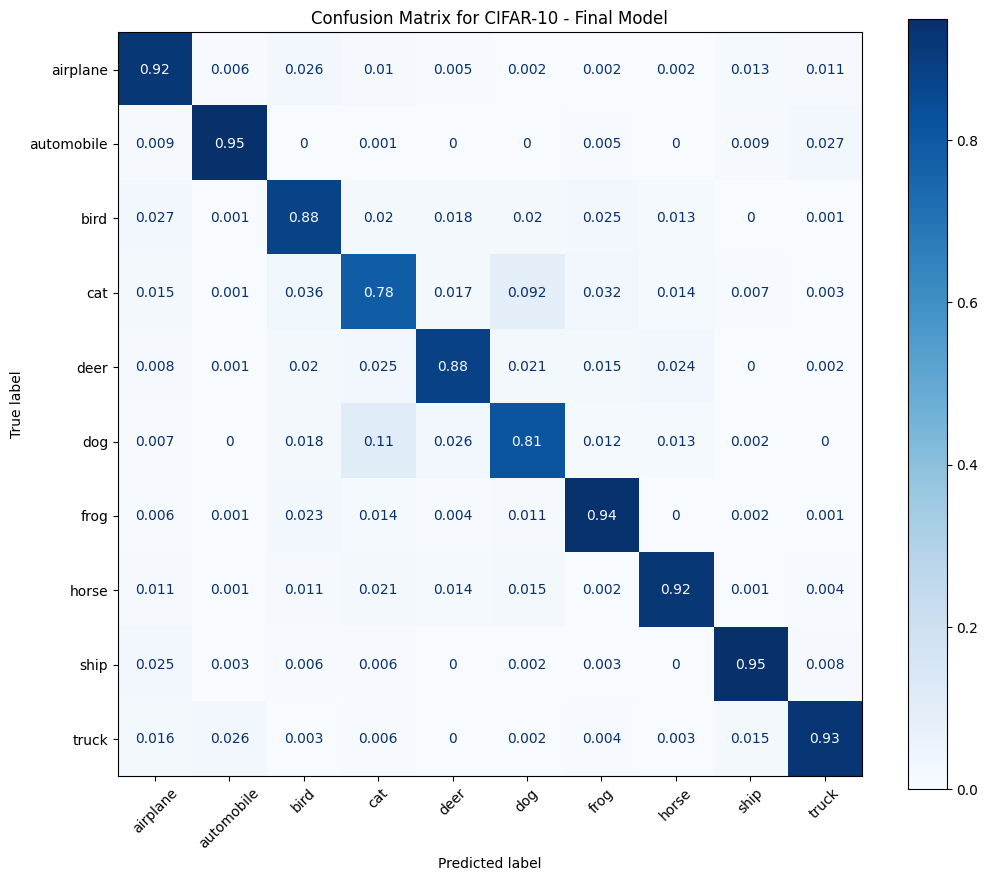

In [43]:
# ---------------------------------------------------------
# 12. Final Confusion Matrix for Best & Fully Trained Model
# ---------------------------------------------------------

fig, ax = plt.subplots(figsize=(12, 10))

# disp = ConfusionMatrixDisplay.from_predictions(
#     all_labels, all_preds
#     , display_labels=dataset.classes
#     , normalize='true'
# )

disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for CIFAR-10 - Final Model")
plt.show();

In [44]:
model

Cifar10CNN_v9(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avgpool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [45]:
# Save both model weights and optimizer state
torch.save({
    'epoch': epochs
    , 'model_state_dict': model.state_dict()
    , 'optimizer_state_dict': optimizer.state_dict()
    , 'loss': loss_fn  # optional
}, "Cifar10CNN_v9_best_100_epochs.pth")

print("Model saved to Cifar10CNN_v9_best_100_epochs.pth")

Model saved to Cifar10CNN_v9_best_100_epochs.pth


In [48]:
# 13. Retrain (If needed)

more_epochs = 100

for epoch in tqdm(range(more_epochs)):
    train_loss, train_acc = train_step(
        model, train_loader, loss_fn, optimizer, accuracy_fn, device)
    test_loss, test_acc = test_step(
        model, test_loader, loss_fn, accuracy_fn, device)
    scheduler.step(test_loss)  # Update learning rate
    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}"
    )

  1%|          | 1/100 [00:11<18:59, 11.51s/it]

Epoch 1/100 - Train Loss: 0.1060, Train Acc: 0.9631 - Test Loss: 0.3893, Test Acc: 0.8970


  2%|▏         | 2/100 [00:23<18:47, 11.51s/it]

Epoch 2/100 - Train Loss: 0.1031, Train Acc: 0.9637 - Test Loss: 0.3911, Test Acc: 0.8975


  3%|▎         | 3/100 [00:34<18:41, 11.56s/it]

Epoch 3/100 - Train Loss: 0.1056, Train Acc: 0.9628 - Test Loss: 0.4016, Test Acc: 0.8968


  4%|▍         | 4/100 [00:46<18:34, 11.61s/it]

Epoch 4/100 - Train Loss: 0.1028, Train Acc: 0.9641 - Test Loss: 0.3937, Test Acc: 0.8970


  5%|▌         | 5/100 [00:57<18:23, 11.61s/it]

Epoch 5/100 - Train Loss: 0.1023, Train Acc: 0.9647 - Test Loss: 0.3932, Test Acc: 0.8961


  6%|▌         | 6/100 [01:10<18:35, 11.86s/it]

Epoch 6/100 - Train Loss: 0.1009, Train Acc: 0.9651 - Test Loss: 0.4024, Test Acc: 0.8944


  7%|▋         | 7/100 [01:21<18:18, 11.81s/it]

Epoch 7/100 - Train Loss: 0.1018, Train Acc: 0.9636 - Test Loss: 0.3977, Test Acc: 0.8967


  8%|▊         | 8/100 [01:33<18:06, 11.81s/it]

Epoch 8/100 - Train Loss: 0.1021, Train Acc: 0.9636 - Test Loss: 0.3960, Test Acc: 0.8972


  9%|▉         | 9/100 [01:45<17:52, 11.79s/it]

Epoch 9/100 - Train Loss: 0.1020, Train Acc: 0.9639 - Test Loss: 0.4006, Test Acc: 0.8966


 10%|█         | 10/100 [01:57<17:39, 11.77s/it]

Epoch 10/100 - Train Loss: 0.0977, Train Acc: 0.9659 - Test Loss: 0.3965, Test Acc: 0.8962


 11%|█         | 11/100 [02:09<17:27, 11.77s/it]

Epoch 11/100 - Train Loss: 0.0993, Train Acc: 0.9652 - Test Loss: 0.4000, Test Acc: 0.8967


 12%|█▏        | 12/100 [02:20<17:15, 11.77s/it]

Epoch 12/100 - Train Loss: 0.1002, Train Acc: 0.9649 - Test Loss: 0.3967, Test Acc: 0.8966


 13%|█▎        | 13/100 [02:32<17:04, 11.78s/it]

Epoch 13/100 - Train Loss: 0.0964, Train Acc: 0.9656 - Test Loss: 0.4058, Test Acc: 0.8965


 14%|█▍        | 14/100 [02:44<16:54, 11.79s/it]

Epoch 14/100 - Train Loss: 0.0999, Train Acc: 0.9645 - Test Loss: 0.4056, Test Acc: 0.8975


 15%|█▌        | 15/100 [02:56<16:43, 11.81s/it]

Epoch 15/100 - Train Loss: 0.1007, Train Acc: 0.9646 - Test Loss: 0.4038, Test Acc: 0.8969


 16%|█▌        | 16/100 [03:08<16:34, 11.84s/it]

Epoch 16/100 - Train Loss: 0.0991, Train Acc: 0.9653 - Test Loss: 0.3940, Test Acc: 0.8986


 17%|█▋        | 17/100 [03:20<16:23, 11.85s/it]

Epoch 17/100 - Train Loss: 0.0984, Train Acc: 0.9639 - Test Loss: 0.4024, Test Acc: 0.8955


 18%|█▊        | 18/100 [03:31<16:12, 11.86s/it]

Epoch 18/100 - Train Loss: 0.0959, Train Acc: 0.9653 - Test Loss: 0.4058, Test Acc: 0.8971


 19%|█▉        | 19/100 [03:43<16:01, 11.87s/it]

Epoch 19/100 - Train Loss: 0.0964, Train Acc: 0.9652 - Test Loss: 0.4081, Test Acc: 0.8967


 20%|██        | 20/100 [03:55<15:50, 11.89s/it]

Epoch 20/100 - Train Loss: 0.0989, Train Acc: 0.9649 - Test Loss: 0.4014, Test Acc: 0.8952


 21%|██        | 21/100 [04:07<15:39, 11.89s/it]

Epoch 21/100 - Train Loss: 0.0948, Train Acc: 0.9657 - Test Loss: 0.4049, Test Acc: 0.8976


 22%|██▏       | 22/100 [04:19<15:27, 11.89s/it]

Epoch 22/100 - Train Loss: 0.0918, Train Acc: 0.9673 - Test Loss: 0.4074, Test Acc: 0.8963


 23%|██▎       | 23/100 [04:31<15:16, 11.90s/it]

Epoch 23/100 - Train Loss: 0.0935, Train Acc: 0.9668 - Test Loss: 0.4111, Test Acc: 0.8971


 24%|██▍       | 24/100 [04:43<15:04, 11.90s/it]

Epoch 24/100 - Train Loss: 0.0954, Train Acc: 0.9659 - Test Loss: 0.4176, Test Acc: 0.8949


 25%|██▌       | 25/100 [04:55<14:53, 11.91s/it]

Epoch 25/100 - Train Loss: 0.0937, Train Acc: 0.9675 - Test Loss: 0.4086, Test Acc: 0.8966


 26%|██▌       | 26/100 [05:07<14:41, 11.91s/it]

Epoch 26/100 - Train Loss: 0.0919, Train Acc: 0.9677 - Test Loss: 0.4101, Test Acc: 0.8973


 27%|██▋       | 27/100 [05:19<14:29, 11.92s/it]

Epoch 27/100 - Train Loss: 0.0946, Train Acc: 0.9655 - Test Loss: 0.4106, Test Acc: 0.8972


 28%|██▊       | 28/100 [05:31<14:18, 11.92s/it]

Epoch 28/100 - Train Loss: 0.0959, Train Acc: 0.9671 - Test Loss: 0.4184, Test Acc: 0.8960


 29%|██▉       | 29/100 [05:43<14:06, 11.92s/it]

Epoch 29/100 - Train Loss: 0.0964, Train Acc: 0.9649 - Test Loss: 0.4070, Test Acc: 0.8959


 30%|███       | 30/100 [05:54<13:54, 11.92s/it]

Epoch 30/100 - Train Loss: 0.0931, Train Acc: 0.9660 - Test Loss: 0.4028, Test Acc: 0.8973


 31%|███       | 31/100 [06:06<13:42, 11.92s/it]

Epoch 31/100 - Train Loss: 0.0926, Train Acc: 0.9663 - Test Loss: 0.4099, Test Acc: 0.8982


 32%|███▏      | 32/100 [06:18<13:30, 11.92s/it]

Epoch 32/100 - Train Loss: 0.0884, Train Acc: 0.9693 - Test Loss: 0.4072, Test Acc: 0.8976


 33%|███▎      | 33/100 [06:30<13:18, 11.92s/it]

Epoch 33/100 - Train Loss: 0.0869, Train Acc: 0.9688 - Test Loss: 0.4108, Test Acc: 0.8978


 34%|███▍      | 34/100 [06:42<13:06, 11.92s/it]

Epoch 34/100 - Train Loss: 0.0901, Train Acc: 0.9680 - Test Loss: 0.4146, Test Acc: 0.8966


 35%|███▌      | 35/100 [06:54<12:55, 11.93s/it]

Epoch 35/100 - Train Loss: 0.0920, Train Acc: 0.9678 - Test Loss: 0.4069, Test Acc: 0.8967


 36%|███▌      | 36/100 [07:06<12:43, 11.93s/it]

Epoch 36/100 - Train Loss: 0.0913, Train Acc: 0.9679 - Test Loss: 0.4159, Test Acc: 0.8986


 37%|███▋      | 37/100 [07:18<12:31, 11.93s/it]

Epoch 37/100 - Train Loss: 0.0868, Train Acc: 0.9693 - Test Loss: 0.4177, Test Acc: 0.8966


 38%|███▊      | 38/100 [07:30<12:19, 11.93s/it]

Epoch 38/100 - Train Loss: 0.0856, Train Acc: 0.9692 - Test Loss: 0.4206, Test Acc: 0.8957


 39%|███▉      | 39/100 [07:42<12:07, 11.93s/it]

Epoch 39/100 - Train Loss: 0.0883, Train Acc: 0.9693 - Test Loss: 0.4156, Test Acc: 0.8971


 40%|████      | 40/100 [07:54<11:56, 11.94s/it]

Epoch 40/100 - Train Loss: 0.0886, Train Acc: 0.9698 - Test Loss: 0.4165, Test Acc: 0.8979


 41%|████      | 41/100 [08:06<11:43, 11.93s/it]

Epoch 41/100 - Train Loss: 0.0891, Train Acc: 0.9689 - Test Loss: 0.4045, Test Acc: 0.8985


 42%|████▏     | 42/100 [08:18<11:31, 11.93s/it]

Epoch 42/100 - Train Loss: 0.0865, Train Acc: 0.9696 - Test Loss: 0.4177, Test Acc: 0.8973


 43%|████▎     | 43/100 [08:29<11:19, 11.93s/it]

Epoch 43/100 - Train Loss: 0.0886, Train Acc: 0.9682 - Test Loss: 0.4164, Test Acc: 0.8970


 44%|████▍     | 44/100 [08:41<11:08, 11.93s/it]

Epoch 44/100 - Train Loss: 0.0868, Train Acc: 0.9684 - Test Loss: 0.4240, Test Acc: 0.8959


 45%|████▌     | 45/100 [08:53<10:56, 11.94s/it]

Epoch 45/100 - Train Loss: 0.0887, Train Acc: 0.9688 - Test Loss: 0.4129, Test Acc: 0.8967


 46%|████▌     | 46/100 [09:05<10:45, 11.94s/it]

Epoch 46/100 - Train Loss: 0.0833, Train Acc: 0.9692 - Test Loss: 0.4213, Test Acc: 0.8963


 47%|████▋     | 47/100 [09:17<10:33, 11.95s/it]

Epoch 47/100 - Train Loss: 0.0842, Train Acc: 0.9698 - Test Loss: 0.4178, Test Acc: 0.8979


 48%|████▊     | 48/100 [09:29<10:21, 11.95s/it]

Epoch 48/100 - Train Loss: 0.0834, Train Acc: 0.9703 - Test Loss: 0.4185, Test Acc: 0.8983


 49%|████▉     | 49/100 [09:41<10:09, 11.95s/it]

Epoch 49/100 - Train Loss: 0.0878, Train Acc: 0.9693 - Test Loss: 0.4113, Test Acc: 0.8983


 50%|█████     | 50/100 [09:53<09:57, 11.94s/it]

Epoch 50/100 - Train Loss: 0.0867, Train Acc: 0.9700 - Test Loss: 0.4289, Test Acc: 0.8963


 51%|█████     | 51/100 [10:05<09:45, 11.94s/it]

Epoch 51/100 - Train Loss: 0.0821, Train Acc: 0.9705 - Test Loss: 0.4181, Test Acc: 0.8973


 52%|█████▏    | 52/100 [10:17<09:33, 11.94s/it]

Epoch 52/100 - Train Loss: 0.0831, Train Acc: 0.9702 - Test Loss: 0.4179, Test Acc: 0.8984


 53%|█████▎    | 53/100 [10:29<09:21, 11.95s/it]

Epoch 53/100 - Train Loss: 0.0827, Train Acc: 0.9703 - Test Loss: 0.4212, Test Acc: 0.8970


 54%|█████▍    | 54/100 [10:41<09:09, 11.95s/it]

Epoch 54/100 - Train Loss: 0.0842, Train Acc: 0.9701 - Test Loss: 0.4270, Test Acc: 0.8960


 55%|█████▌    | 55/100 [10:53<08:57, 11.95s/it]

Epoch 55/100 - Train Loss: 0.0830, Train Acc: 0.9688 - Test Loss: 0.4138, Test Acc: 0.8991


 56%|█████▌    | 56/100 [11:05<08:46, 11.96s/it]

Epoch 56/100 - Train Loss: 0.0804, Train Acc: 0.9712 - Test Loss: 0.4244, Test Acc: 0.8962


 57%|█████▋    | 57/100 [11:17<08:33, 11.95s/it]

Epoch 57/100 - Train Loss: 0.0824, Train Acc: 0.9715 - Test Loss: 0.4159, Test Acc: 0.8988


 58%|█████▊    | 58/100 [11:29<08:21, 11.95s/it]

Epoch 58/100 - Train Loss: 0.0821, Train Acc: 0.9709 - Test Loss: 0.4263, Test Acc: 0.8968


 59%|█████▉    | 59/100 [11:41<08:10, 11.95s/it]

Epoch 59/100 - Train Loss: 0.0821, Train Acc: 0.9706 - Test Loss: 0.4279, Test Acc: 0.8968


 60%|██████    | 60/100 [11:53<07:57, 11.95s/it]

Epoch 60/100 - Train Loss: 0.0795, Train Acc: 0.9717 - Test Loss: 0.4251, Test Acc: 0.8980


 61%|██████    | 61/100 [12:05<07:46, 11.95s/it]

Epoch 61/100 - Train Loss: 0.0796, Train Acc: 0.9716 - Test Loss: 0.4266, Test Acc: 0.8953


 62%|██████▏   | 62/100 [12:17<07:34, 11.95s/it]

Epoch 62/100 - Train Loss: 0.0848, Train Acc: 0.9701 - Test Loss: 0.4275, Test Acc: 0.8970


 63%|██████▎   | 63/100 [12:29<07:22, 11.97s/it]

Epoch 63/100 - Train Loss: 0.0799, Train Acc: 0.9718 - Test Loss: 0.4268, Test Acc: 0.8964


 64%|██████▍   | 64/100 [12:41<07:10, 11.97s/it]

Epoch 64/100 - Train Loss: 0.0806, Train Acc: 0.9704 - Test Loss: 0.4190, Test Acc: 0.8970


 65%|██████▌   | 65/100 [12:52<06:58, 11.96s/it]

Epoch 65/100 - Train Loss: 0.0807, Train Acc: 0.9721 - Test Loss: 0.4317, Test Acc: 0.8963


 66%|██████▌   | 66/100 [13:04<06:46, 11.96s/it]

Epoch 66/100 - Train Loss: 0.0803, Train Acc: 0.9713 - Test Loss: 0.4185, Test Acc: 0.8988


 67%|██████▋   | 67/100 [13:16<06:34, 11.95s/it]

Epoch 67/100 - Train Loss: 0.0811, Train Acc: 0.9717 - Test Loss: 0.4192, Test Acc: 0.8978


 68%|██████▊   | 68/100 [13:28<06:22, 11.95s/it]

Epoch 68/100 - Train Loss: 0.0808, Train Acc: 0.9707 - Test Loss: 0.4268, Test Acc: 0.8972


 69%|██████▉   | 69/100 [13:40<06:10, 11.97s/it]

Epoch 69/100 - Train Loss: 0.0775, Train Acc: 0.9723 - Test Loss: 0.4291, Test Acc: 0.8974


 70%|███████   | 70/100 [13:52<05:59, 11.98s/it]

Epoch 70/100 - Train Loss: 0.0786, Train Acc: 0.9721 - Test Loss: 0.4223, Test Acc: 0.8993


 71%|███████   | 71/100 [14:04<05:48, 12.01s/it]

Epoch 71/100 - Train Loss: 0.0779, Train Acc: 0.9726 - Test Loss: 0.4312, Test Acc: 0.8965


 72%|███████▏  | 72/100 [14:16<05:36, 12.02s/it]

Epoch 72/100 - Train Loss: 0.0781, Train Acc: 0.9726 - Test Loss: 0.4347, Test Acc: 0.8980


 73%|███████▎  | 73/100 [14:28<05:24, 12.03s/it]

Epoch 73/100 - Train Loss: 0.0768, Train Acc: 0.9723 - Test Loss: 0.4400, Test Acc: 0.8962


 74%|███████▍  | 74/100 [14:40<05:12, 12.02s/it]

Epoch 74/100 - Train Loss: 0.0735, Train Acc: 0.9745 - Test Loss: 0.4303, Test Acc: 0.8982


 75%|███████▌  | 75/100 [14:52<05:00, 12.01s/it]

Epoch 75/100 - Train Loss: 0.0748, Train Acc: 0.9730 - Test Loss: 0.4307, Test Acc: 0.8994


 76%|███████▌  | 76/100 [15:04<04:48, 12.02s/it]

Epoch 76/100 - Train Loss: 0.0785, Train Acc: 0.9718 - Test Loss: 0.4390, Test Acc: 0.8967


 77%|███████▋  | 77/100 [15:17<04:37, 12.05s/it]

Epoch 77/100 - Train Loss: 0.0749, Train Acc: 0.9737 - Test Loss: 0.4329, Test Acc: 0.8973


 78%|███████▊  | 78/100 [15:29<04:26, 12.11s/it]

Epoch 78/100 - Train Loss: 0.0779, Train Acc: 0.9725 - Test Loss: 0.4338, Test Acc: 0.8980


 79%|███████▉  | 79/100 [15:41<04:15, 12.15s/it]

Epoch 79/100 - Train Loss: 0.0755, Train Acc: 0.9724 - Test Loss: 0.4412, Test Acc: 0.8956


 80%|████████  | 80/100 [15:53<04:02, 12.15s/it]

Epoch 80/100 - Train Loss: 0.0765, Train Acc: 0.9734 - Test Loss: 0.4344, Test Acc: 0.8967


 81%|████████  | 81/100 [16:06<03:54, 12.35s/it]

Epoch 81/100 - Train Loss: 0.0757, Train Acc: 0.9730 - Test Loss: 0.4359, Test Acc: 0.8968


 82%|████████▏ | 82/100 [16:18<03:42, 12.34s/it]

Epoch 82/100 - Train Loss: 0.0743, Train Acc: 0.9735 - Test Loss: 0.4352, Test Acc: 0.8972


 83%|████████▎ | 83/100 [16:31<03:28, 12.27s/it]

Epoch 83/100 - Train Loss: 0.0725, Train Acc: 0.9741 - Test Loss: 0.4377, Test Acc: 0.8986


 84%|████████▍ | 84/100 [16:43<03:15, 12.22s/it]

Epoch 84/100 - Train Loss: 0.0729, Train Acc: 0.9742 - Test Loss: 0.4394, Test Acc: 0.8981


 85%|████████▌ | 85/100 [16:55<03:02, 12.19s/it]

Epoch 85/100 - Train Loss: 0.0704, Train Acc: 0.9755 - Test Loss: 0.4477, Test Acc: 0.8976


 86%|████████▌ | 86/100 [17:07<02:50, 12.19s/it]

Epoch 86/100 - Train Loss: 0.0707, Train Acc: 0.9747 - Test Loss: 0.4444, Test Acc: 0.8991


 87%|████████▋ | 87/100 [17:19<02:38, 12.18s/it]

Epoch 87/100 - Train Loss: 0.0728, Train Acc: 0.9742 - Test Loss: 0.4544, Test Acc: 0.8966


 88%|████████▊ | 88/100 [17:31<02:25, 12.16s/it]

Epoch 88/100 - Train Loss: 0.0736, Train Acc: 0.9740 - Test Loss: 0.4359, Test Acc: 0.8988


 89%|████████▉ | 89/100 [17:43<02:13, 12.14s/it]

Epoch 89/100 - Train Loss: 0.0701, Train Acc: 0.9748 - Test Loss: 0.4402, Test Acc: 0.8986


 90%|█████████ | 90/100 [17:55<02:01, 12.12s/it]

Epoch 90/100 - Train Loss: 0.0725, Train Acc: 0.9749 - Test Loss: 0.4416, Test Acc: 0.8980


 91%|█████████ | 91/100 [18:07<01:48, 12.11s/it]

Epoch 91/100 - Train Loss: 0.0709, Train Acc: 0.9748 - Test Loss: 0.4443, Test Acc: 0.8973


 92%|█████████▏| 92/100 [18:19<01:36, 12.09s/it]

Epoch 92/100 - Train Loss: 0.0708, Train Acc: 0.9746 - Test Loss: 0.4444, Test Acc: 0.8986


 93%|█████████▎| 93/100 [18:32<01:24, 12.08s/it]

Epoch 93/100 - Train Loss: 0.0701, Train Acc: 0.9749 - Test Loss: 0.4461, Test Acc: 0.8958


 94%|█████████▍| 94/100 [18:44<01:12, 12.07s/it]

Epoch 94/100 - Train Loss: 0.0719, Train Acc: 0.9753 - Test Loss: 0.4530, Test Acc: 0.8977


 95%|█████████▌| 95/100 [18:56<01:00, 12.06s/it]

Epoch 95/100 - Train Loss: 0.0726, Train Acc: 0.9747 - Test Loss: 0.4390, Test Acc: 0.8982


 96%|█████████▌| 96/100 [19:08<00:48, 12.05s/it]

Epoch 96/100 - Train Loss: 0.0731, Train Acc: 0.9745 - Test Loss: 0.4467, Test Acc: 0.8978


 97%|█████████▋| 97/100 [19:20<00:36, 12.05s/it]

Epoch 97/100 - Train Loss: 0.0676, Train Acc: 0.9760 - Test Loss: 0.4485, Test Acc: 0.8967


 98%|█████████▊| 98/100 [19:32<00:24, 12.05s/it]

Epoch 98/100 - Train Loss: 0.0689, Train Acc: 0.9754 - Test Loss: 0.4375, Test Acc: 0.8976


 99%|█████████▉| 99/100 [19:44<00:12, 12.05s/it]

Epoch 99/100 - Train Loss: 0.0705, Train Acc: 0.9750 - Test Loss: 0.4484, Test Acc: 0.8984


100%|██████████| 100/100 [19:56<00:00, 11.96s/it]

Epoch 100/100 - Train Loss: 0.0694, Train Acc: 0.9746 - Test Loss: 0.4403, Test Acc: 0.8980


In [ ]:
# train_acc, test_acc

(0.9711212060702875, 0.8944818037974683)

In [49]:
train_acc, test_acc

(0.9746156150159745, 0.8980419303797469)

In [50]:
# 14a. Final evaluation on test set with sklearn metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        X = test_transform_batch(X)   # normalize just like during training
        y_pred = model(X)
        all_preds.extend(y_pred.argmax(dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

Cifar10CNN_v9(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avgpool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [51]:
# 14b. Compute metrics

print("\nFinal Evaluation with Sklearn Metrics")
print("Accuracy:", accuracy_score(all_labels, all_preds))
# print("\nConfusion Matrix:\n", confusion_matrix(all_labels, all_preds))
# print("\nClassification Report:\n", classification_report(all_labels, all_preds))

# Convert back to tensors for torchmetrics
all_preds_tensor = torch.tensor(all_preds)
all_labels_tensor = torch.tensor(all_labels)

print("\nFinal Evaluation with torchmetrics Metrics\n", cm_tensor)
cm = ConfusionMatrix(num_classes=10, task='multiclass')
cm_tensor = cm(all_preds_tensor, all_labels_tensor)
# cm_tensor
print("\nClassification Report:\n", classification_report(all_labels, all_preds))


Final Evaluation with Sklearn Metrics
Accuracy: 0.8976

Final Evaluation with torchmetrics Metrics
 tensor([[730,  25,  35,  69,  35,   1,  11,  24,  12,  58],
        [  4, 910,   3,   2,   1,   0,  18,   0,   4,  58],
        [ 40,   4, 636, 158,  63,   9,  66,  22,   0,   2],
        [  7,   2,  33, 805,  43,  17,  74,  12,   3,   4],
        [  6,   1,  28,  71, 809,   5,  49,  26,   1,   4],
        [  1,   4,  24, 412,  62, 413,  36,  45,   2,   1],
        [  6,   4,  21,  57,  14,   0, 896,   1,   0,   1],
        [  3,   1,  24,  91,  70,  12,  10, 786,   0,   3],
        [ 40,  28,  16,  63,  14,   0,  36,   6, 758,  39],
        [  6,  46,   3,  25,   4,   1,  15,   5,   3, 892]])

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      1000
           1       0.97      0.93      0.95      1000
           2       0.86      0.88      0.87      1000
           3       0.81      0.78      0.79      1000
  

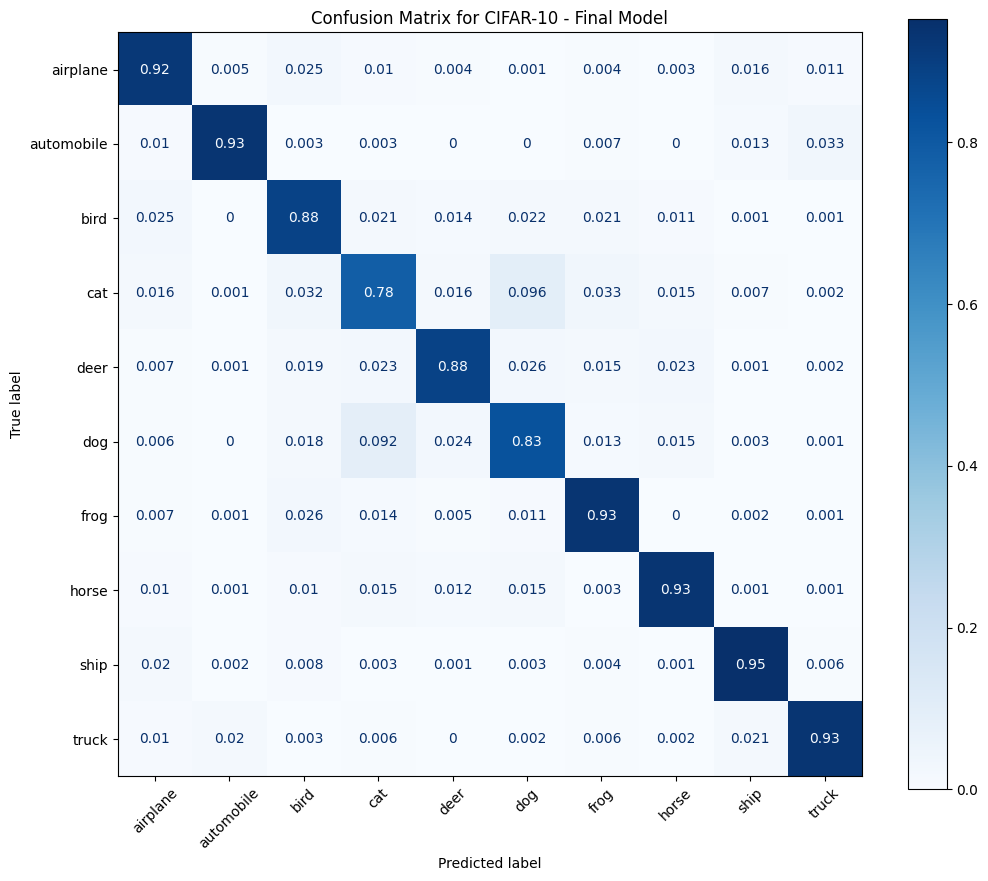

In [54]:
# 15. Final Confusion Matrix for Best & Fully Trained Model

fig, ax = plt.subplots(figsize=(12, 10))

# disp = ConfusionMatrixDisplay.from_predictions(
#     all_labels, all_preds
#     , display_labels=dataset.classes
#     , normalize='true'
# )

disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for CIFAR-10 - Final Model")
plt.show();

In [55]:
# 16a. Save both model weights and optimizer state (in case you want to retrain, run add'l epochs, etc.)
torch.save({
    'epoch': epochs + more_epochs
    , 'model_state_dict': model.state_dict()
    , 'optimizer_state_dict': optimizer.state_dict()
    , 'loss': loss_fn,  # optional
}, "Cifar10CNN_v9_more_retrained_200_epochs_best.pth")

print("Model saved to Cifar10CNN_v9_more_retrained_200_epochs__best.pth")

Model saved to Cifar10CNN_v9_more_retrained_200_epochs__best.pth


In [56]:
# 16b. Save best weights  (for eval mode only, so can only eval new data w/ weights; no add'l training;)
torch.save(model.state_dict(), "Cifar10CNN_v9_more_retrained_best_weights.pth")

In [57]:
# Cifar10CNN_v9_best

torch.save(model.state_dict(), "Cifar10CNN_v9_best_weights.pth")

In [58]:
print("\nClassification Report:\n", classification_report(all_labels, all_preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      1000
           1       0.97      0.93      0.95      1000
           2       0.86      0.88      0.87      1000
           3       0.81      0.78      0.79      1000
           4       0.92      0.88      0.90      1000
           5       0.82      0.83      0.83      1000
           6       0.90      0.93      0.92      1000
           7       0.93      0.93      0.93      1000
           8       0.94      0.95      0.94      1000
           9       0.94      0.93      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

